# Аугентация на практике.

Импорт необходимых библиотек

In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%cd drive/MyDrive/YaMlProject
%ls

/content/drive/MyDrive/YaMlProject
core/  data/  models/  notebooks/  README.md  requirements.txt


In [3]:
import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

from core.datasets import get_ds

Скачаем датасеты 

In [4]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', back=0, batch_size=1)

Напишем функцию для отображения датасета с применнеными вариантами аугментаций

In [5]:
def draw_aug_ds(transformer):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        img = np.array(transformer(Image.fromarray((train_ds[i][0][0] * 255).astype(np.uint8), 'RGB')))
        plt.imshow(img / 255, cmap=plt.cm.binary)
        plt.title(train_ds[i][1][0])
        plt.axis('off')
    plt.show()

Напишем все варианты аугментации

In [6]:
crop = tv.transforms.CenterCrop(size=(28, 22))
inverter = tv.transforms.RandomInvert(p=0.4)
posterizer = tv.transforms.RandomPosterize(bits=6, p=0.4)
jitter = tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5)
perspective = tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4)
affine = tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1))
gray_scale = tv.transforms.Grayscale(num_output_channels=3)
solarizer = tv.transforms.RandomSolarize(threshold=100.0, p=0.4)
equalizer = tv.transforms.RandomEqualize(p=0.4)

Теперь будем комбинировать их и проверять на моделе. На фото изображен график обучения модели без агументации. Как можно заметить по графику лосса есть переобучение. 
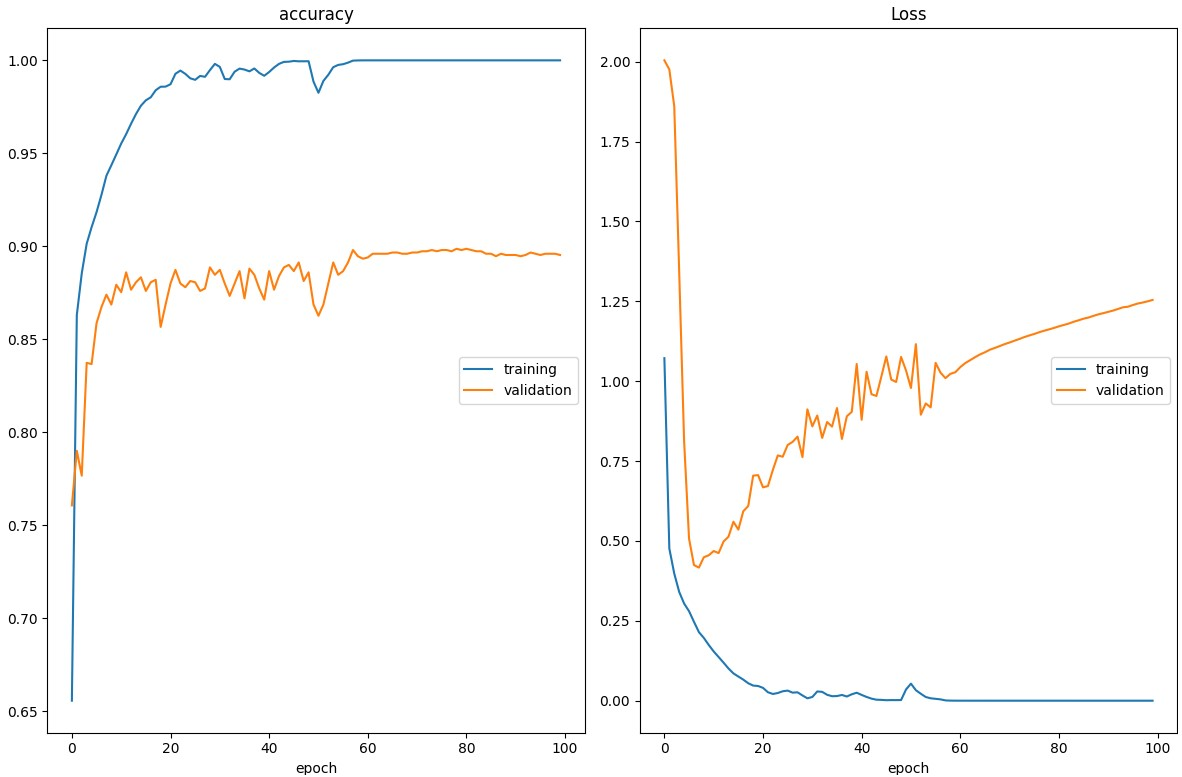

Для проверки работоспособности аугментаций, мы будем использовать эту же модель.

In [7]:
model_retrain = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_retrain.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (512, 30, 30, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (512, 28, 28, 64)         18496     
                                                                 
 batch_normalization (BatchN  (512, 28, 28, 64)        256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (512, 14, 14, 64)        0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (512, 12, 12, 64)         36928     
                                                                 
 average_pooling2d_1 (Averag  (512, 6, 6, 64)          0

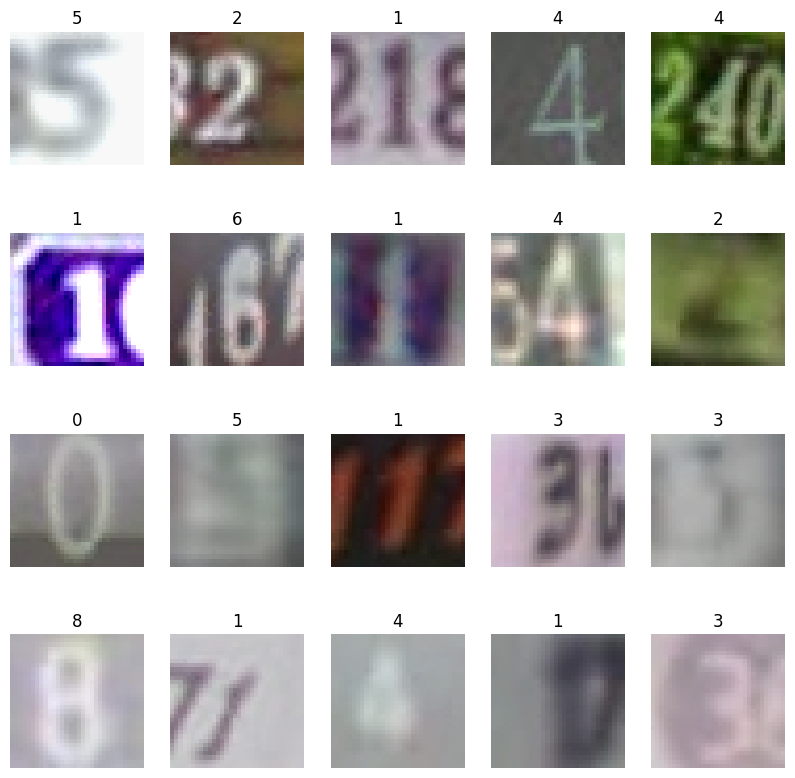

In [8]:
transformer1 = tv.transforms.Compose([
    jitter,
    inverter
])
draw_aug_ds(transformer1)

In [9]:
train_ds.transform = transformer1
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

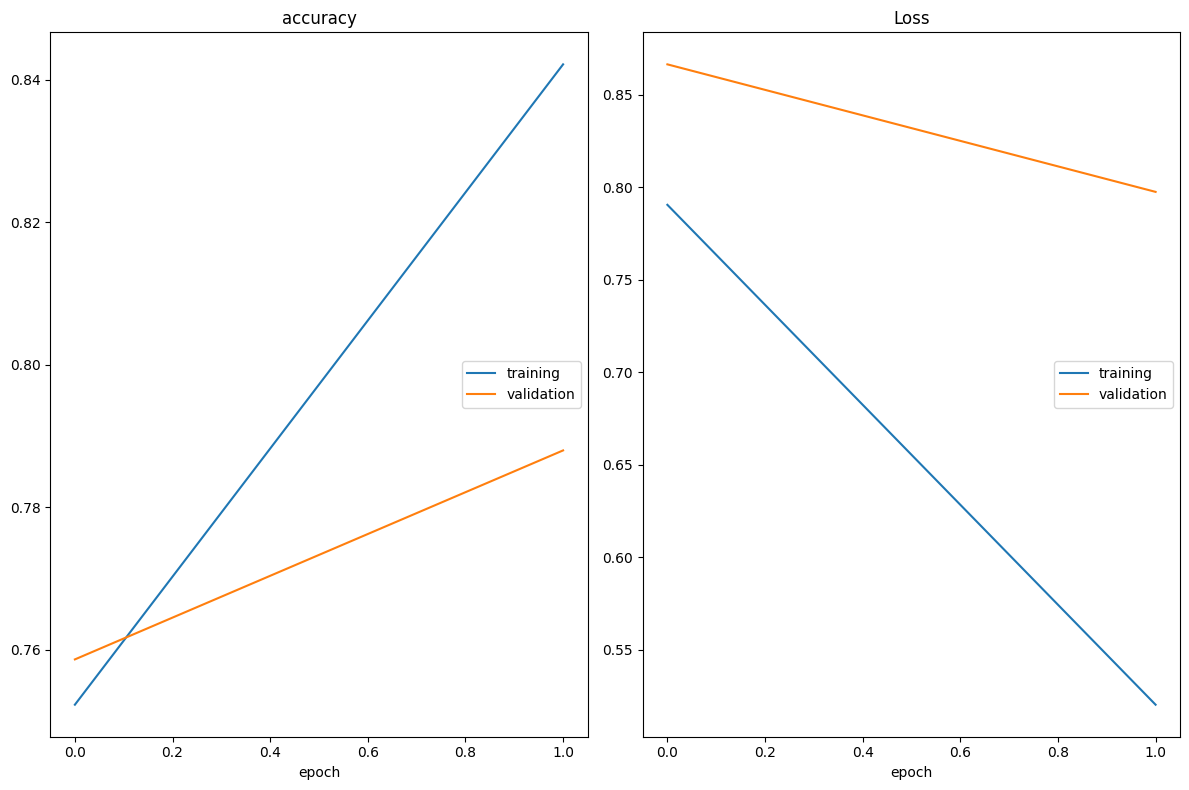

accuracy
	training         	 (min:    0.752, max:    0.842, cur:    0.842)
	validation       	 (min:    0.759, max:    0.788, cur:    0.788)
Loss
	training         	 (min:    0.520, max:    0.791, cur:    0.520)
	validation       	 (min:    0.798, max:    0.866, cur:    0.798)


KeyboardInterrupt: ignored

In [10]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

In [ ]:
transformer2 = tv.transforms.Compose([
    tv.transforms.RandomPerspective(distortion_scale=0.1, p=1.0),
    tv.transforms.RandomAffine(degrees=(-7, 7), translate=(0, 0.1), scale=(0.95, 1))
])
draw_aug_ds(transformer2)

In [ ]:
train_ds.transform = transformer2
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

вывод

----

In [ ]:
transformer3 = tv.transforms.Compose([
    posterizer,
    affine,
])
draw_aug_ds(transformer3)

In [ ]:
train_ds.transform = transformer3
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

In [ ]:
transformer4 = tv.transforms.Compose([
    jitter,
    affine,
    perspective
])
draw_aug_ds(transformer4)

In [ ]:
train_ds.transform = transformer4
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

In [ ]:
transformer5 = tv.transforms.Compose([
    posterizer,
    jitter,
    affine,
])
draw_aug_ds(transformer5)

In [ ]:
train_ds.transform = transformer5
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

In [ ]:
transformer6 = tv.transforms.Compose([
    posterizer,
    perspective
])
draw_aug_ds(transformer6)

In [ ]:
train_ds.transform = transformer6
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

In [ ]:
transformer7 = tv.transforms.Compose([
    jitter,
    inverter,
    perspective
])
draw_aug_ds(transformer7)

In [ ]:
train_ds.transform = transformer7
model = tf.keras.models.clone_model(model_retrain)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

В некст моделях мы используем кроп поэтому меняем инпут шейп...

# перепиши, что я написал сверху

In [ ]:
model_retrain_crop = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 22, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_retrain_crop.summary()

In [ ]:
transformer8 = tv.transforms.Compose([
    crop,
    posterizer,
    affine
])
draw_aug_ds(transformer8)

In [ ]:
train_ds.transform = transformer8
model = tf.keras.models.clone_model(model_retrain_crop)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)

In [ ]:
transformer9 = tv.transforms.Compose([
    crop,
    inverter,
    perspective,
])
draw_aug_ds(transformer9)

In [ ]:
train_ds.transform = transformer9
model = tf.keras.models.clone_model(model_retrain_crop)
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=False)